<h1>Deep Learning- CNN Visualization, Grad-CAM, Eigen-CAM, Transfer Learning, Heatmaps<h1/>

<p style="font-size:15px; font-weight:normal;">
In this project, we classify rice images using two methods: first, a CNN model, and second, a transfer learning model. After creating the models, we visualize the results to see which model performs better.
<p/>

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import glob
from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time
from tensorflow import keras
from tensorflow.keras import layers, models
from google.colab import files

# Checking if GPU is available
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


In [8]:
# Set random seeds for reproducibility

np.random.seed(42) # NumPy random generator

tf.random.set_seed(42) # TensorFlow random generator

# Dataset Path and Class Names

We define the base path to our rice image dataset and list the class names

In [16]:
base_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

#classnames
categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Load Rice Image Dataset into a DataFrame

We first define a function to load the rice image dataset into a pandas DataFrame.  
This function collects the image paths and their corresponding labels.

In [17]:
def load_rice_dataset(base_path, categories):
    image_paths = []
    labels = []

    for category in categories:
        folder_path = os.path.join(base_path, category)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(category)

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    return df

# create DataFrame
rice_df = load_rice_dataset(base_path,categories)
rice_df.head()


,image_path,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio


I personally prefer using a DataFrame because it makes performing operations on the data easier

In [18]:
print(f"Dataset Summary")
print(f"Total images: {len(rice_df)}")

print("\nImages per category:")
print(rice_df['label'].value_counts())

print("\nSample entries:")
print(rice_df.head())

Dataset Summary
Total images: 75000

Images per category:
label
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64

Sample entries:
                                          image_path    label
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio


# Visualize Sample Images

In [19]:
def visualize_samples(df, num_samples=3):
    plt.figure(figsize=(15, 10))
    categories = df['label'].unique()

    for i, category in enumerate(categories):
        category_imgs = df[df['label'] == category]['image_path'].values
        samples = np.random.choice(category_imgs, min(num_samples, len(category_imgs)), replace=False)

        for j, img_path in enumerate(samples):
            plt.subplot(len(categories), num_samples, i*num_samples + j + 1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{category}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

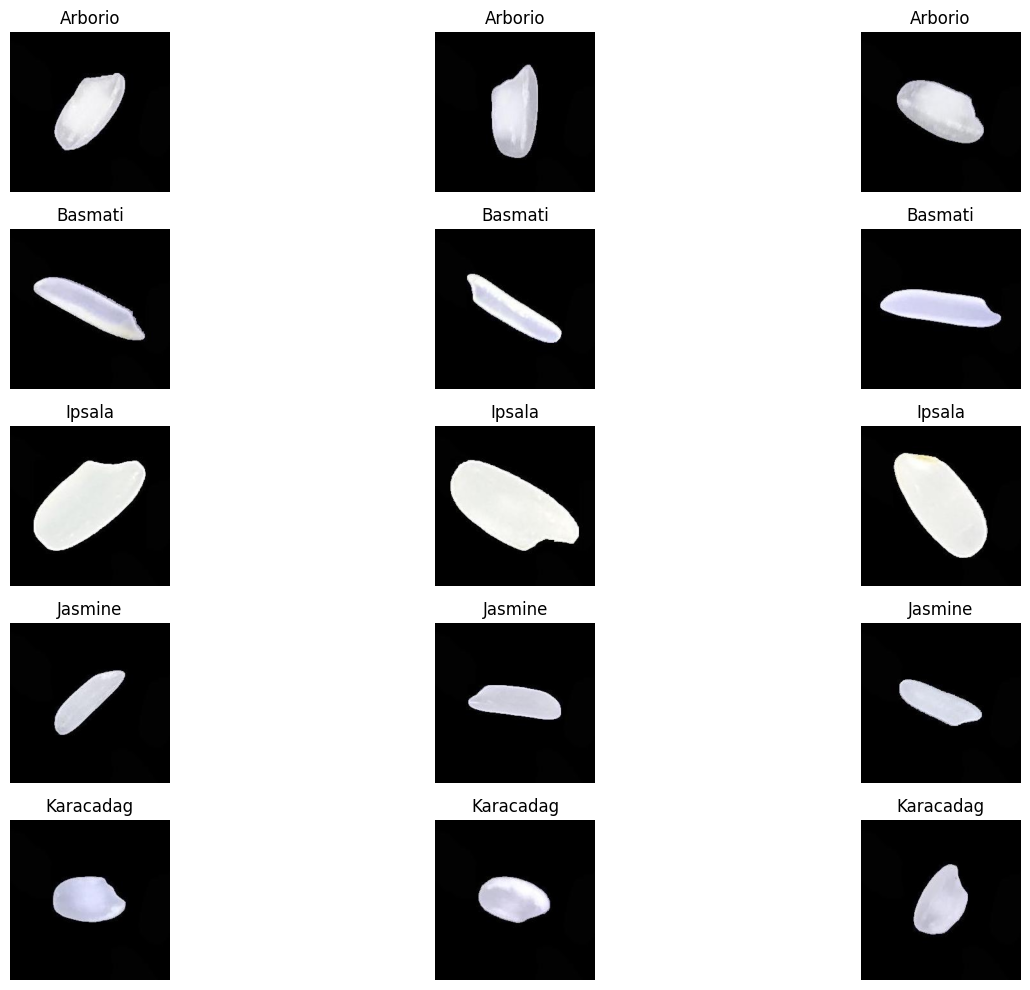


DataFrame saved to 'rice_dataset.csv'


In [20]:
try:
    visualize_samples(rice_df)
except Exception as e:
    print(f"Error visualizing images: {e}")

rice_df.to_csv('rice_dataset.csv', index=False)
print("\nDataFrame saved to 'rice_dataset.csv'")

# Splitting the Dataset

Now, we split the dataset into three parts: training, validation, and testing.

In [21]:
train_df, temp_df = train_test_split(rice_df,test_size=0.4, random_state=42, stratify=rice_df['label'])
val_df, test_df =train_test_split(temp_df, test_size=0.5, random_state=42,stratify=temp_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 45000
Validation set size: 15000
Test set size: 15000


# Data Augmentation and Data Generators

In this step, we prepare the dataset for training, validation, and testing.  
We use **data generators** to efficiently feed images to the model in batches and optionally apply **data augmentation** to improve model generalization.

## What we do:

1. **Set image size and batch size:**  
   - Resize all images to 128x128 pixels (`img_size`).  
   - Use a batch size of 64 (`batch_size`).

2. **Define Data Augmentation for the training set:**  
   - Rescale pixel values to [0,1].  
   - Randomly flip images horizontally and vertically.  
   - Apply small rotations, zooms, shifts, and brightness changes.  
   This helps the model generalize better by seeing slightly varied versions of the images.

3. **Prepare validation and test generators:**  
   - Only rescaling is applied (no augmentation), so we evaluate the model on original data.

4. **Create generators using `flow_from_dataframe`:**  
   - Generates batches of images and corresponding labels from pandas DataFrames (`train_df`, `val_df`, `test_df`).  
   - Labels are encoded as integers (`class_mode='sparse'`).  
   - Shuffle training data for better training dynamics; validation and test sets are not shuffled.
    - **Why we use generators:** They allow us to handle large datasets efficiently, perform real-time data augmentation, provide batch-wise data, and keep the code clean.





In [22]:
img_size = (128, 128)
batch_size = 64

#Data Agumentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,    #random zooming.
    width_shift_range=0.1,  #random panning.
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    vertical_flip=True,
    fill_mode='nearest'
)

#rescale the validaditon and test set
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# create genetors
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',    #Image file path column
    y_col='label',         #Label column
    target_size=img_size,  #Scales images to 128x128
    class_mode='sparse',   #Labels are used as integers
    batch_size=batch_size, #Sends 64 samples at each step
    shuffle=True           #Shuffles the training set
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False
)


test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False
)

Found 45000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


# Basic CNN Model for Rice Classification

In this step, we define a Convolutional Neural Network (CNN) to classify rice images into five categories.  
We built the model using Keras Sequential API, stacking layers that help the network learn both low-level and high-level features from the images.

The function `create_cnn_model()` starts with an input layer that accepts images of size 128x128 with three color channels.  
We then add convolutional layers to extract features such as edges, textures, and shapes. Batch normalization layers are used after each convolution to stabilize and speed up the training process, while max pooling layers reduce the spatial dimensions and make the model more efficient. Dropout layers are added to prevent overfitting by randomly deactivating a fraction of neurons during training.

Instead of flattening all features at the end, we use Global Average Pooling, which summarizes the feature maps into a single vector and helps the model generalize better.  

Finally, we add fully connected dense layers to perform classification. Batch normalization and dropout are also applied here to improve training stability and prevent overfitting. The output layer uses softmax activation to produce probabilities for the five rice classes.

Overall, this CNN architecture allows the model to progressively learn from raw images, extract important patterns, and classify them accurately.



In [25]:
#Basic CNN Model
from tensorflow.keras import regularizers

def create_cnn_model():
    model = keras.Sequential([
        layers.InputLayer(shape=(128,128,3)),

        # First block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Second block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),


        # Global Average Pooling (over Flatten)
        layers.GlobalAveragePooling2D(),

        # Dense block
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(5, activation='softmax')
    ])
    return model

# Creating the model
cnn_model = create_cnn_model()

# See model summary
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,517 (95.77 KB)

 Trainable params: 24,197 (94.52 KB)

 Non-trainable params: 320 (1.25 KB)

# Compile CNN Model and Define Callbacks

After creating the CNN model, we need to compile it and define some callbacks to improve training.

We compile the model using the Adam optimizer with a small learning rate.  
The loss function is `sparse_categorical_crossentropy` because our labels are integers representing five rice classes.  
We also track `accuracy` as a metric to monitor how well the model performs during training.

Next, we define several callbacks:

1. **EarlyStopping:**  
   - Monitors the validation loss (`val_loss`) and stops training if it doesn’t improve for a set number of epochs (`patience=5`).  
   - It also restores the model weights from the best epoch to prevent overfitting.

2. **ReduceLROnPlateau:**  
   - Reduces the learning rate by a factor (0.5) if the validation loss stops improving for a few epochs (`patience=3`).  
   - This helps the optimizer fine-tune the model during training.

3. **ModelCheckpoint:**  
   - Saves the best model based on validation accuracy (`val_accuracy`).  
   - Ensures that the best version of the model is stored for later use.  
   - We define separate checkpoints for the CNN model and the transfer learning model.

Overall, these steps make training more efficient, prevent overfitting, and help us keep the best performing model.


In [38]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience= 3,
    mode='max',
    min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    '/kaggle/working/best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_weights_only=False
)

checkpoint_tl = keras.callbacks.ModelCheckpoint(
    '/kaggle/working/best_tl_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)




In [ ]:
# We train the model
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[early_stopping,reduce_lr,checkpoint],
    epochs=20,
    verbose=1
)

files.download('/kaggle/working/best_cnn_model.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5383 - loss: 1.2046
Epoch 1: val_accuracy improved from -inf to 0.20380, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 254s 347ms/step - accuracy: 0.5385 - loss: 1.2040 - val_accuracy: 0.2038 - val_loss: 3.9227 - learning_rate: 1.0000e-04
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8537 - loss: 0.4258
Epoch 2: val_accuracy improved from 0.20380 to 0.26567, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 235s 333ms/step - accuracy: 0.8537 - loss: 0.4258 - val_accuracy: 0.2657 - val_loss: 2.7674 - learning_rate: 1.0000e-04
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8978 - loss: 0.3114
Epoch 3: val_accuracy improved from 0.26567 to 0.27240, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 238s 338ms/step - accuracy: 0.8978 - loss: 0.3114 - val_accuracy: 0.2724 - val_loss: 3.4176 - learning_rate: 1.0000e-04
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9135 - loss: 0.2654
Epoch 4: val_accuracy improved from 0.27240 to 0.43700, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 234s 333ms/step - accuracy: 0.9135 - loss: 0.2654 - val_accuracy: 0.4370 - val_loss: 1.8814 - learning_rate: 1.0000e-04
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9274 - loss: 0.2311
Epoch 5: val_accuracy improved from 0.43700 to 0.45713, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 233s 330ms/step - accuracy: 0.9274 - loss: 0.2311 - val_accuracy: 0.4571 - val_loss: 1.9515 - learning_rate: 5.0000e-05
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9328 - loss: 0.2093
Epoch 6: val_accuracy did not improve from 0.45713
704/704 ━━━━━━━━━━━━━━━━━━━━ 233s 332ms/step - accuracy: 0.9328 - loss: 0.2093 - val_accuracy: 0.4042 - val_loss: 2.7708 - learning_rate: 5.0000e-05
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9389 - loss: 0.1935
Epoch 7: val_accuracy improved from 0.45713 to 0.49053, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 234s 332ms/step - accuracy: 0.9389 - loss: 0.1935 - val_accuracy: 0.4905 - val_loss: 2.3145 - learning_rate: 5.0000e-05
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9395 - loss: 0.1857
Epoch 8: val_accuracy improved from 0.49053 to 0.63113, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 234s 332ms/step - accuracy: 0.9395 - loss: 0.1857 - val_accuracy: 0.6311 - val_loss: 1.5436 - learning_rate: 2.5000e-05
Epoch 9/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9444 - loss: 0.1742
Epoch 9: val_accuracy did not improve from 0.63113
704/704 ━━━━━━━━━━━━━━━━━━━━ 231s 328ms/step - accuracy: 0.9444 - loss: 0.1742 - val_accuracy: 0.5897 - val_loss: 1.6362 - learning_rate: 2.5000e-05
Epoch 10/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9421 - loss: 0.1792
Epoch 10: val_accuracy improved from 0.63113 to 0.73647, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 232s 329ms/step - accuracy: 0.9421 - loss: 0.1792 - val_accuracy: 0.7365 - val_loss: 1.3167 - learning_rate: 2.5000e-05
Epoch 11/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9485 - loss: 0.1646
Epoch 11: val_accuracy did not improve from 0.73647
704/704 ━━━━━━━━━━━━━━━━━━━━ 232s 330ms/step - accuracy: 0.9485 - loss: 0.1646 - val_accuracy: 0.6419 - val_loss: 1.8241 - learning_rate: 1.2500e-05
Epoch 12/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9511 - loss: 0.1581
Epoch 12: val_accuracy improved from 0.73647 to 0.75447, saving model to /content/best_cnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 237s 337ms/step - accuracy: 0.9511 - loss: 0.1581 - val_accuracy: 0.7545 - val_loss: 1.3571 - learning_rate: 1.2500e-05
Epoch 13/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9504 - loss: 0.1613
Epoch 13: val_accuracy did not improve from 0.75447
704/704 ━━━━━━━━━━━━━━━━━━━━ 235s 334ms/step - accuracy: 0.9504 - loss: 0.1614 - val_accuracy: 0.7061 - val_loss: 1.6750 - learning_rate: 1.2500e-05
Epoch 14/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9510 - loss: 0.1597
Epoch 14: val_accuracy did not improve from 0.75447
704/704 ━━━━━━━━━━━━━━━━━━━━ 232s 329ms/step - accuracy: 0.9510 - loss: 0.1597 - val_accuracy: 0.7258 - val_loss: 1.3763 - learning_rate: 6.2500e-06
Epoch 15/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9487 - loss: 0.1608
Epoch 15: val_accuracy did not improve from 0.75447
704/704 ━━━━━━━━━━━━━━━━━━━━ 232s 329ms/step - accuracy: 0.9487 - loss: 0.1608 - val_accuracy: 0.7436 - val_loss: 1.3830 - learnin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After training the model, I first looked at the training accuracy and validation accuracy. I noticed that while the training accuracy was high, the validation accuracy remained around 0.75. I think this might be because one of the classes is either underrepresented or the model is not predicting it correctly. So, that’s why I plotted the graph to visualize the training and validation accuracy over epochs.

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

def evaluate_model(model, test_generator, categories):
    test_generator.reset()
    steps =int (np.ceil(test_generator.samples / test_generator.batch_size))

    test_loss, test_accuracy = model.evaluate(test_generator, steps=steps, verbose=1)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    y_pred_prob = model.predict(test_generator, steps=steps, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=categories))

    return test_accuracy




235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7373 - loss: 1.3216
Test Accuracy: 0.7359
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step


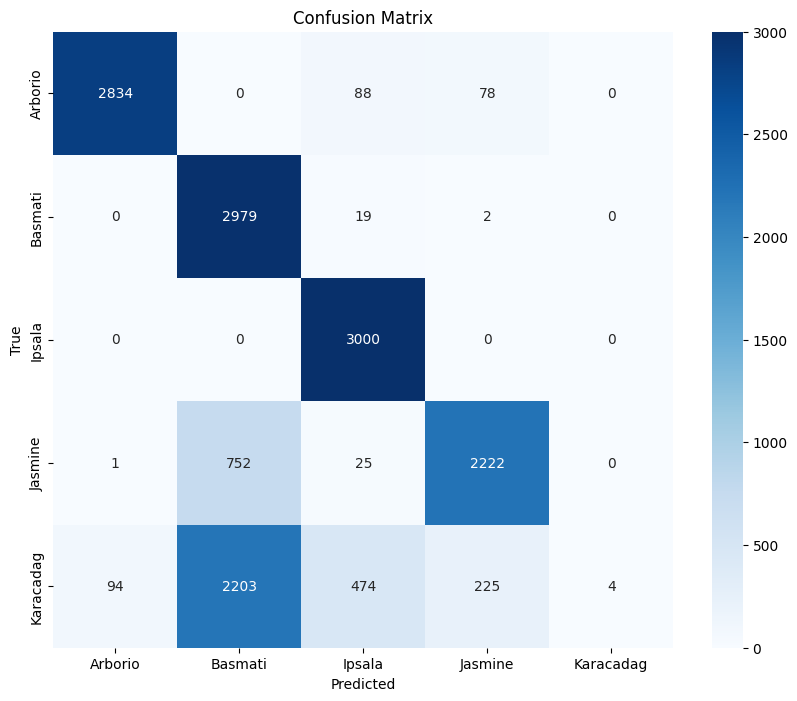


Classification Report:
              precision    recall  f1-score   support

     Arborio       0.97      0.94      0.96      3000
     Basmati       0.50      0.99      0.67      3000
      Ipsala       0.83      1.00      0.91      3000
     Jasmine       0.88      0.74      0.80      3000
   Karacadag       1.00      0.00      0.00      3000

    accuracy                           0.74     15000
   macro avg       0.84      0.74      0.67     15000
weighted avg       0.84      0.74      0.67     15000



In [ ]:
acc_cnn = evaluate_model(cnn_model, test_generator, categories)

### Confusion Analysis from Classification Report


The model performs very well on the Arborio class, achieving high precision and recall, which means almost all Arborio samples are correctly classified. For Basmati, the recall is extremely high, indicating that nearly all actual Basmati samples are identified correctly. However, the precision is low, suggesting that about half of the predictions labeled as Basmati are actually from other classes, likely due to confusion with similar classes. Ipsala is recognized successfully, with the model correctly identifying almost all examples and making very few mistakes. Jasmine shows moderate performance; some examples are correctly classified while others are misclassified into different classes. The Karacadag class, on the other hand, is almost never recognized, with recall at zero. This indicates that all true Karacadag samples are being misclassified, most likely as Basmati, which aligns with the low precision seen for Basmati. Overall, the model struggles primarily with distinguishing between Basmati and Karacadag, while other classes are handled more accurately.


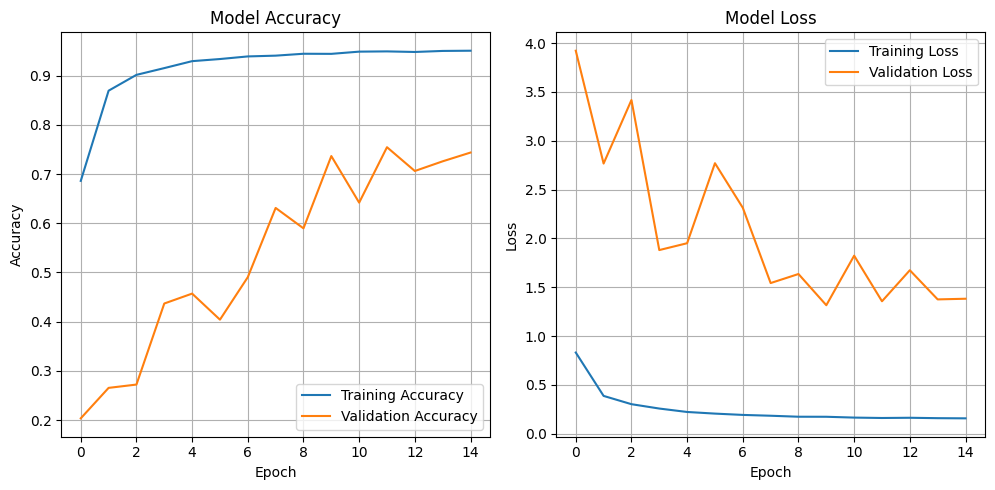

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Learning rate plot (eğer callback kullanılmışsa)
    if 'lr' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In this graph, we are looking for signs of overfitting. We can see that the training accuracy increases while the validation accuracy also improves. Similarly, the training loss decreases alongside the validation loss. This indicates that the model is not overfitting and is generalizing well to the validation data.

After this, I increased the number of layers by adding an additional convolutional block. I also lowered the learning rate significantly and applied class weighting, giving more weight to the Karacadag class. However, I did not include this second attempt in the report because the results were very poor. After failing to improve the model, I decided to use transfer learning instead.

# Transfer Learning with MobileNetV2

In this step, we implement **transfer learning** to improve the model’s performance, especially for challenging classes like Karacadag.

We use **MobileNetV2** as the base model, which has been pre-trained on ImageNet. By setting `include_top=False`, we remove the original classification layers so that we can adapt the model to our rice dataset. The input shape is defined as 128x128 pixels with 3 color channels. At first, we freeze the pre-trained weights to preserve the learned features and prevent them from being updated during the initial training stages.

On top of the base model, we add a **Global Average Pooling** layer to reduce the spatial dimensions of the feature maps into a single vector. This is followed by a fully connected **dense layer** with 128 neurons and ReLU activation, and a **dropout layer** with a rate of 0.5 to prevent overfitting. Finally, the **output layer** uses softmax activation to predict probabilities for the five rice classes.

The model is compiled using the **Adam optimizer** with a small learning rate of 0.0001, `sparse_categorical_crossentropy` as the loss function, and `accuracy` as the evaluation metric.  

This setup leverages the feature extraction capabilities of MobileNetV2 while allowing the new dense layers to adapt to our specific rice classification task.


In [40]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)

base_model.trainable = False  # Freeze pre-trained weights at the start

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

tl_model = Model(inputs=base_model.input, outputs=output)
tl_model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
#training the model
history_tl = tl_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, checkpoint_tl])

model_path = "/kaggle/working/best_tl_model.h5"
tl_model.save(model_path)
print("Model kaydedildi:", model_path)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7456 - loss: 0.6926
Epoch 1: val_accuracy improved from -inf to 0.95587, saving model to /kaggle/working/best_tl_model.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 389s 535ms/step - accuracy: 0.7458 - loss: 0.6922 - val_accuracy: 0.9559 - val_loss: 0.1391 - learning_rate: 1.0000e-04
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9450 - loss: 0.1670
Epoch 2: val_accuracy did not improve from 0.95587
704/704 ━━━━━━━━━━━━━━━━━━━━ 335s 476ms/step - accuracy: 0.9450 - loss: 0.1670 - val_accuracy: 0.9429 - val_loss: 0.1589 - learning_rate: 1.0000e-04
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9584 - loss: 0.1280
Epoch 3: val_accuracy did not improve from 0.95587
704/704 ━━━━━━━━━━━━━━━━━━━━ 323s 459ms/step - accuracy: 0.9584 - loss: 0.1280 - val_accuracy: 0.9470 - val_loss: 0.1479 - learning_rate: 1.0000e-04
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9622 - loss: 0.11

In [75]:
import pickle
from tensorflow.keras.models import load_model

# save Model
model_path = "/kaggle/working/best_tl_model.h5"
tl_model.save(model_path)
print("Model saved:", model_path)

# save History
history_path = "/kaggle/working/history_tl.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history_tl.history, f)

print("History saved:", history_path)


Model saved: /kaggle/working/best_tl_model.h5
History saved: /kaggle/working/history_tl.pkl


### Classification Report Analysis after Transfer Learning

After applying transfer learning with MobileNetV2, the model's performance improved significantly. The overall accuracy reaches approximately 95.6%, 

After visualizing the model’s performance, we can see that both training and validation accuracy are high and there is no significant gap between them. The same observation applies to the loss curves. Overall, we can conclude that the model performs well and provides reliable predictions.

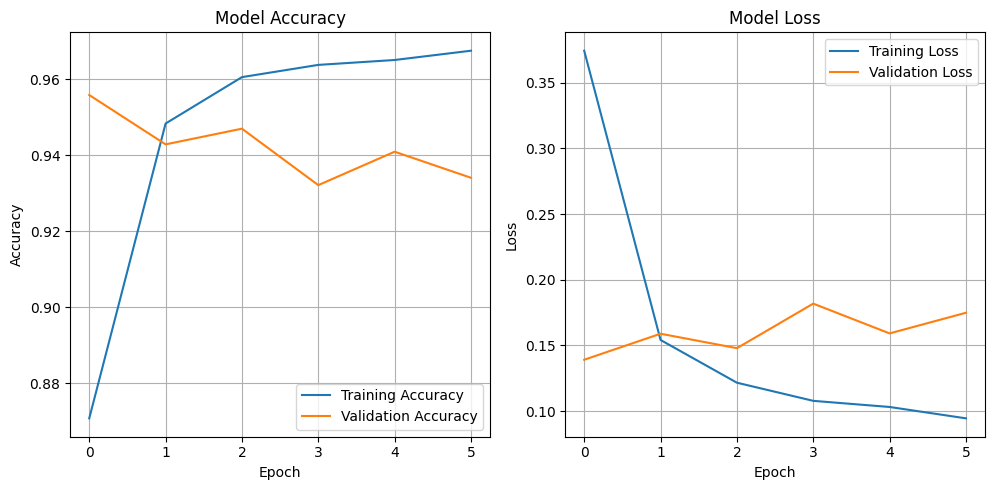

In [44]:
def plot_training_history(history_tl):
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history_tl.history['accuracy'], label='Training Accuracy')
    plt.plot(history_tl.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history_tl.history['loss'], label='Training Loss')
    plt.plot(history_tl.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Learning rate plot (eğer callback kullanılmışsa)
    if 'lr' in history_tl.history:
        plt.subplot(1, 3, 3)
        plt.plot(history_tl.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history_tl)

Looking at the individual classes, Arborio, Basmati, Ipsala, and Jasmine are all classified very accurately, with precision and recall values close to or above 0.95. The Karacadag class, which was previously almost never recognized, now shows a recall of 0.893 and an F1-score of 0.938. This indicates that the model is much better at identifying Karacadag images while still distinguishing it from Basmati.  

Overall, the confusion between Basmati and Karacadag has been largely resolved, and the model now provides reliable predictions across all five rice classes.


In [46]:
def evaluate_model(model, test_generator, categories):
    test_generator.reset()
    steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

    test_loss, test_accuracy = model.evaluate(test_generator, steps=steps, verbose=1)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    y_pred_prob = model.predict(test_generator, steps=steps, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=categories, digits=4))

    return test_accuracy


235/235 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.9558 - loss: 0.1358

Test Loss: 0.1344
Test Accuracy: 0.9563
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 144ms/step


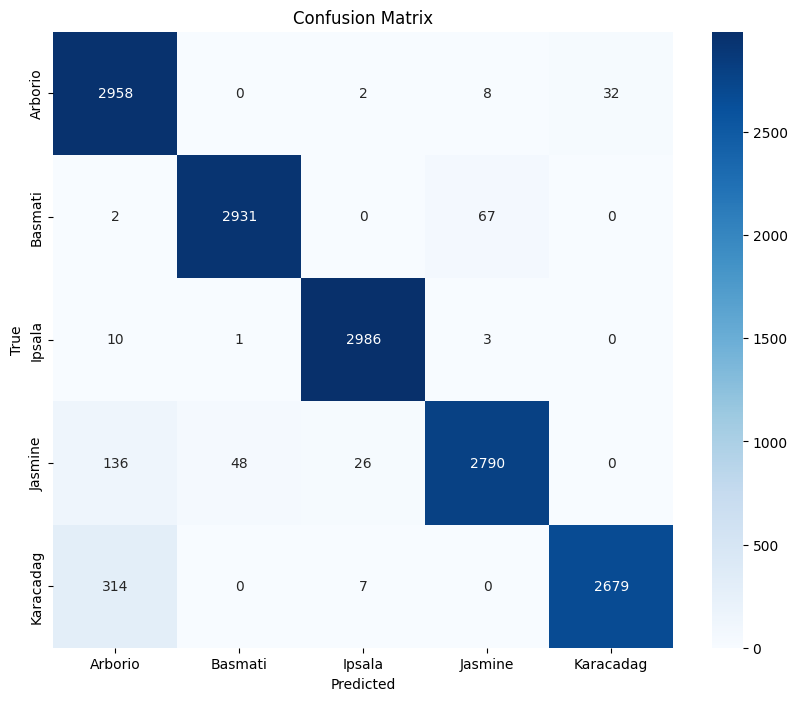


Classification Report:
              precision    recall  f1-score   support

     Arborio     0.8649    0.9860    0.9215      3000
     Basmati     0.9836    0.9770    0.9803      3000
      Ipsala     0.9884    0.9953    0.9919      3000
     Jasmine     0.9728    0.9300    0.9509      3000
   Karacadag     0.9882    0.8930    0.9382      3000

    accuracy                         0.9563     15000
   macro avg     0.9596    0.9563    0.9565     15000
weighted avg     0.9596    0.9563    0.9565     15000



In [47]:
acc_tl = evaluate_model(tl_model, test_generator, categories)

# CAM and Grad-CAM Visualization

These functions help visualize which regions of an image the model focuses on when making predictions, making the model’s decisions more interpretable.

- **Grad-CAM (`make_gradcam_heatmap`)** generates a heatmap by computing gradients of the predicted class with respect to the last convolutional layer, highlighting important areas for the model's decision.  
- **Eigen-CAM (`eigen_cam_heatmap`)** uses the principal component of the feature maps’ covariance to create a heatmap emphasizing relevant regions.  
- **Overlay (`visualize_cam`)** resizes and overlays the heatmap on the original image, producing a visual explanation of where the model "looks" when predicting.


In [68]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Grad-CAM heatmap oluşturur"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def eigen_cam_heatmap(img_array, model, last_conv_layer_name):
    """Eigen-CAM heatmap oluşturur"""
    feature_extractor = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output]
    )

    conv_features = feature_extractor(img_array)[0].numpy()
    h, w, c = conv_features.shape
    flattened = conv_features.reshape(-1, c)

    cov = np.cov(flattened, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal_component = eigvecs[:, -1]

    heatmap = np.dot(flattened, principal_component).reshape(h, w)
    heatmap = np.maximum(heatmap, 0)

    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    return heatmap

def visualize_cam(original_img_path, heatmap, target_size=(224, 224)):
    """CAM heatmap'ini orijinal görüntü üzerine bindirir"""
    img_orig = cv2.imread(original_img_path)
    img_orig = cv2.resize(img_orig, target_size)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, target_size)
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

    return img_orig, superimposed_img

In [76]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def quick_cam_test_all_classes(test_df, tl_model):
    
    try:
        classes = test_df['label'].unique()
        for cls in classes:
            first_sample = test_df[test_df['label'] == cls].iloc[0]
            sample_path = first_sample['image_path']

            print(f"Tested: {cls} - {sample_path}")

            # Upload image
            img = image.load_img(sample_path, target_size=(128, 128))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0) / 255.0

            # Find the last conv layer
            conv_layers = [layer.name for layer in tl_model.layers if 'conv' in layer.name.lower()]
            last_conv = conv_layers[-1]

            # Calculate CAM
            gradcam = make_gradcam_heatmap(x, tl_model, last_conv)
            eigencam = eigen_cam_heatmap(x, tl_model, last_conv)

            # Visualize
            orig, gradcam_vis = visualize_cam(sample_path, gradcam, target_size=(128, 128))
            _, eigencam_vis = visualize_cam(sample_path, eigencam, target_size=(128, 128))

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(orig)
            plt.title(f"Original\n{cls}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(gradcam_vis)
            plt.title("Grad-CAM")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(eigencam_vis)
            plt.title("Eigen-CAM")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        print("Successful test for all classes!")

    except Exception as e:
        print(f"Quick test error: {e}")
        import traceback
        print(traceback.format_exc())


These images show explainability analysis of a deep learning model classifying different rice types. Each row has three columns: original image (left), Grad-CAM heatmap (center), and Eigen-CAM heatmap (right).

**Karacadag:** Oval, short grain. Both CAMs focus on the center and edges.  
**Jasmine:** Long, thin grain. CAMs highlight the grain along its length, capturing its characteristic shape.  
**Ipsala:** Wider, oval grain. Activations spread across the grain, reflecting overall shape.  
**Basmati:** Very long, thin grain. CAMs emphasize length, Eigen-CAM more focused than Grad-CAM.  
**Arborio:** Short, nearly round grain. Both CAMs cover the entire grain. "Successful test for all classes!" indicates correct classification.

Overall, the model attends to morphological features (length, width, shape) specific to each rice type. Grad-CAM and Eigen-CAM show similar activation regions, confirming the model has learned distinguishing features effectively.


Tested: Karacadag - /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (9786).jpg


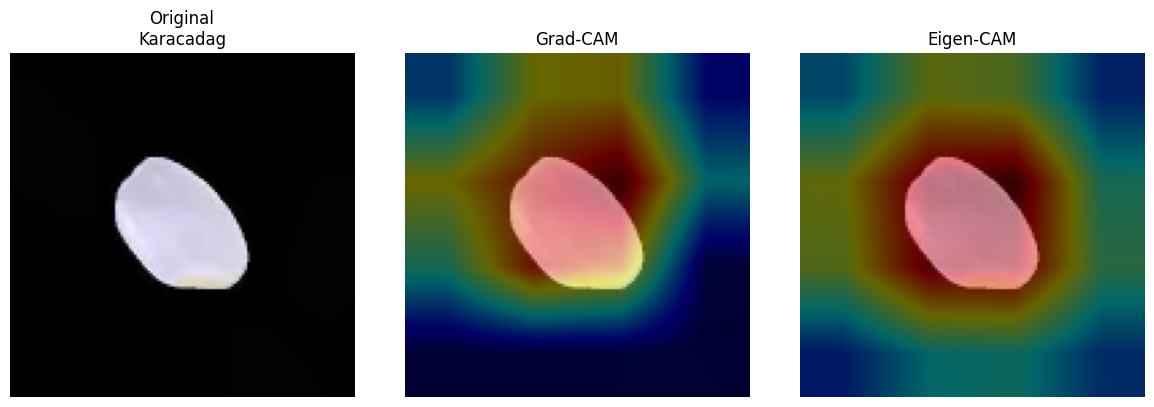

Tested: Jasmine - /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Jasmine/Jasmine (6486).jpg


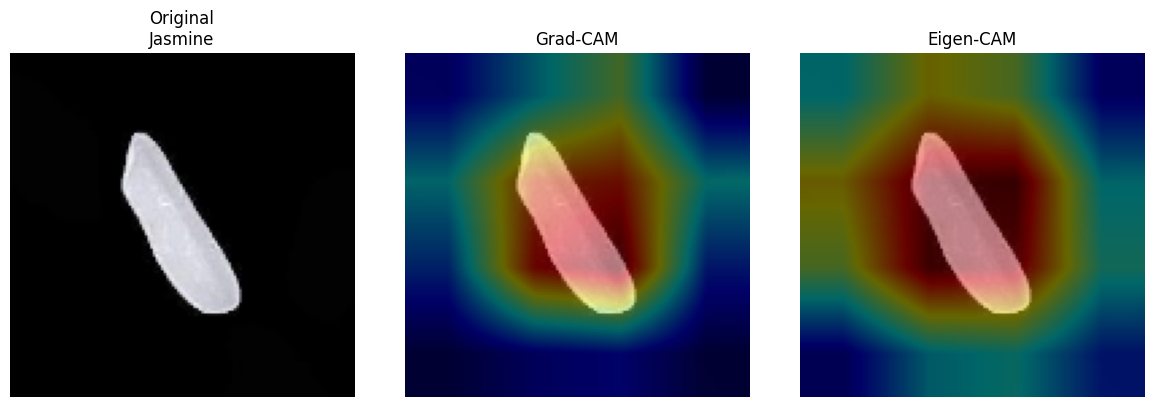

Tested: Ipsala - /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala/Ipsala (11339).jpg


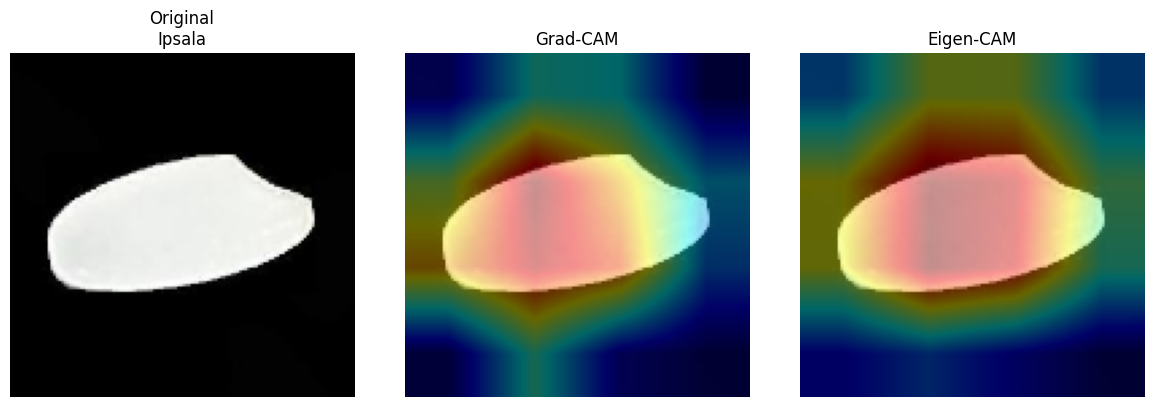

Tested: Basmati - /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati/basmati (11588).jpg


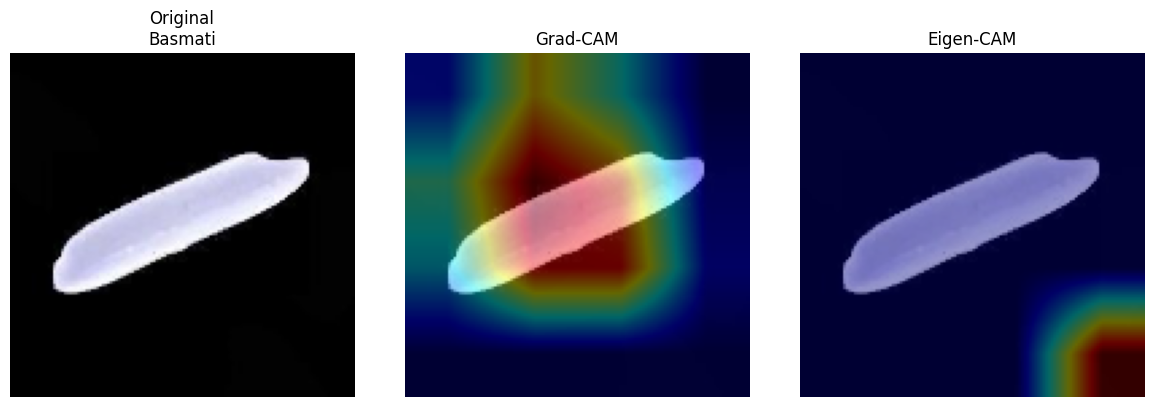

Tested: Arborio - /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Arborio/Arborio (9810).jpg


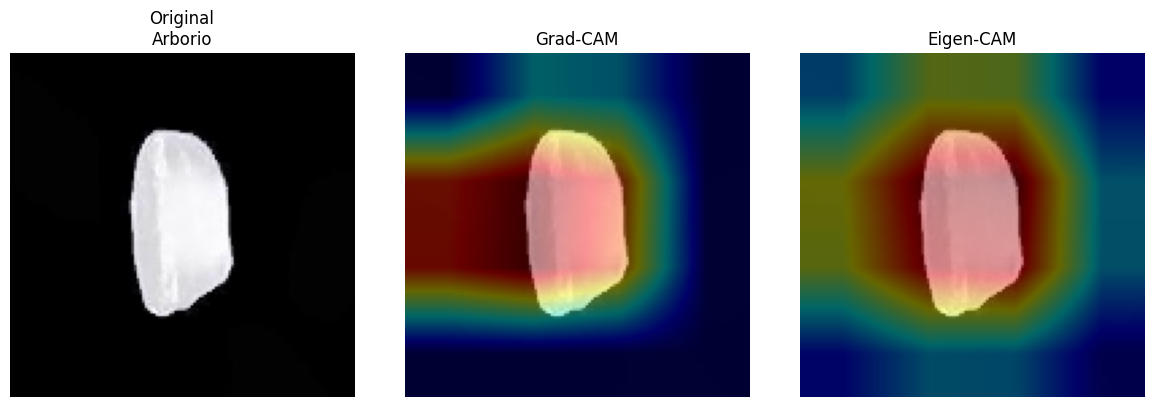

Successful test for all classes!


In [77]:
quick_cam_test_all_classes(test_df, tl_model)
